```
                            (#%(//***,.                                         
                          %@&&&&&&&&%&&&&&&#                                    
                       ,@@@@@&&%#(/*,,*(#%&&@&. ,#%&&&&&@&&#,                   
                      %&@@@@&&%(*,.....,*(#%&&@&&@@@@@&%&&@@@@@@@&              
                     /%@&@@@&%%(/******/(##%&&@@&@@&#((////(((#%&@@@@           
            /&@@@@@@&%@@@&@@&%%###(((#%%%&&&&&&&##%&#///*/(&@@@&%%&@@@#         
        (@@@@&/@@@@@@@@#%@@@@&&%%%%*/#&%#%&&&@@@@@@&#//&%                       
      @@@&&((##(%&@@@@@@&%@%@&@(%#%%%%%%,./(/.(/&((&@.                          
    &@@%//***,****(#%&@@@@@@@@%&*/#/.*(///*,//.#%%,&                            
   &@@(/**,,,,,,,,,,/&&@@@@@@@@&. ((/  /#%####%&&&(&                            
  &@@#(#%@@@&*        %@@@@@@@@&*#%&/%((((%&&%%&&@@&                            
 .@@@@@                   (#&&&&@@@@&&&//,,,(/(##/                             ,
 .@&                      %@@&&(%(,*(/,..*(#/(%#((#%(.                       ,.@
  .                   .(&%&@@@&%##**(#@/,  %@%%@#/#,%&&&                    ,.@@
                  *%&@@&(/#%&@&@@@#(.. .,,*/*&@@@///,%%&@%                 ,.@@@
                &@@@&&&%&@*,(#@@&@@@@@@(. ,&@&%@@&(,%,&&@@/              .,(@@@@
               &@@%%(/#%&@@,,*(%@%@@@@@@@&##/(%&&%&#/#&@@@&           ..*.@@@@@@
               @@@&%%%&&&@@@,%,&%&&&@@&%((&(%&@@@@%@#&&&&&@&.        ..*,@@@@@@@
               #@@@&%(((%&&@%#,(%%@@&@&%*@@@@@@@@@@@%@&&/(#&&*...  ...*,@@@@@@@@
               .%&&&(  ,(%&&@&*(&&&&&%/,&@&(@@&%&@@@&@@@&**#&&&,. ../*(@@@@@@@@&
         .......%&@@@&&&@@@@@&/&&&%%#/(&@&(%%@%%%%@&@&&@@&&./#%%* ./*&@@@@@@@@@@
##############(,*@@&&&&&&&@@@&&@@@@&#*#&&@&#%&%%#%%%@@&%@&&&#,(%&%*/@@@@@@@@@@@@
##############(*.@@@%%#&&&@@@&@&%#(*#&@&#(#&&%&&##(,%&&&%%&@&&&@%/&@@@@@@@@@@@@@
((##########(((/.%@@@#(#%&&@&&&%(*,(#%%&&(%#%#%&%#(,.#%&@@&@(,,%*#@@@@@@@@@@@@@@
//(##########(,...@@@@@&&%@@&&%#((#%&&&%&%%&%%%&&%    ##%&@@@@/*&%@@@@@@@@@@@@@@
(###########((/,,.(@@@&/,(@&&&&%%&&&&&%%&&&%%%%&&........%%%%**@@@@@@@@&@@@@@@@@
###(,,,,*/(((((*,(%@@@@@@@@&&&&&&&@&%/&&%#%%%%&&#./#(*//(((%*/@@@@@@@@@@@@@@@@@@
,*###(((((((((((#&&@@&@@@@&@@&&@@&&(&#**,**,,,********//((%*#@@@@@@@@@@@@@@@@@@@
///////////////(#%&&@@&@@@@@@@@@&(**,*,,,,,,,,,*%//%##(##(*&@@@@@@@@@@@@@@@@@@@@
///////////////////(##%&@@@@@@@&%******&/(##%###########/*@@@@@@@@@@@@@@@@@@@@@@
////////////////////((#%%%%&@@@&&#,(/#%*,*/*.&%########//@@@@@@@@@@@@@@@@@@@@@@&
%%(*/////////////////////(///////#@@@@@@@@/(%*,*/(.,&&*(@@@@@@@@@@@@@@@@@@@@@@(/
```
# Goblin Mode

In [ ]:
# ignore this
# This is the version of torch I am using if you happen to be on windows and have a decent GPU.
# pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html

In [10]:
import os
import cv2
import copy
import json
import math
import numpy as np
from time import time
import mediapipe as mp
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose

# Setting up the Pose function.
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.3, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation.
mp_drawing = mp.solutions.drawing_utils 

In [4]:
myPath = os.getcwd()
myYogaPath = os.path.join(myPath, 'yoga')
myYogaFolders = os.listdir(myYogaPath)

In [5]:
def load_chechpoint(myPath):
    goodFile = open(os.path.join(myPath, 'good.json'), 'r')
    badFile = open(os.path.join(myPath, 'bad.json'), 'r')
    goods = json.load(goodFile)
    bads = json.load(badFile)
    goodFile.close()
    badFile.close()
    return goods, bads

def save_chechpoint(goods, bads):
    good_json = json.dumps(goods, indent = 4) 
    bad_object = json.dumps(bads, indent = 4) 
    with open("good.json", "w") as good_file:
        good_file.write(good_json)
    with open("bad.json", "w") as bad_file:
        bad_file.write(bad_object)

In [6]:
def detectPose(image, pose, display=True):
    '''
    This function performs pose detection on an image.
    Args:
        image: The input image with a prominent person whose pose landmarks needs to be detected.
        pose: The pose setup function required to perform the pose detection.
        display: A boolean value that is if set to true the function displays the original input image, the resultant image, 
                 and the pose landmarks in 3D plot and returns nothing.
    Returns:
        output_image: The input image with the detected pose landmarks drawn.
        landmarks: A list of detected landmarks converted into their original scale.
    '''
    
    # Create a copy of the input image.
    output_image = image.copy()
    
    # Convert the image from BGR into RGB format.
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Perform the Pose Detection.
    results = pose.process(imageRGB)
    
    # Retrieve the height and width of the input image.
    height, width, _ = image.shape
    
    # Initialize a list to store the detected landmarks.
    landmarks = []
    
    # Check if any landmarks are detected.
    if results.pose_landmarks:
    
        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(image=output_image, landmark_list=results.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS)
        
        # Iterate over the detected landmarks.
        for landmark in results.pose_landmarks.landmark:
            
            # Append the landmark into the list.
            landmarks.append((int(landmark.x * width), int(landmark.y * height),
                                  (landmark.z * width)))
    
    # Check if the original input image and the resultant image are specified to be displayed.
    if display:
    
        # Display the original input image and the resultant image.
        plt.figure(figsize=[22,22])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output Image");plt.axis('off');
        
        # Also Plot the Pose landmarks in 3D.
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        
    # Otherwise
    else:
        
        # Return the output image and the found landmarks.
        return output_image, landmarks

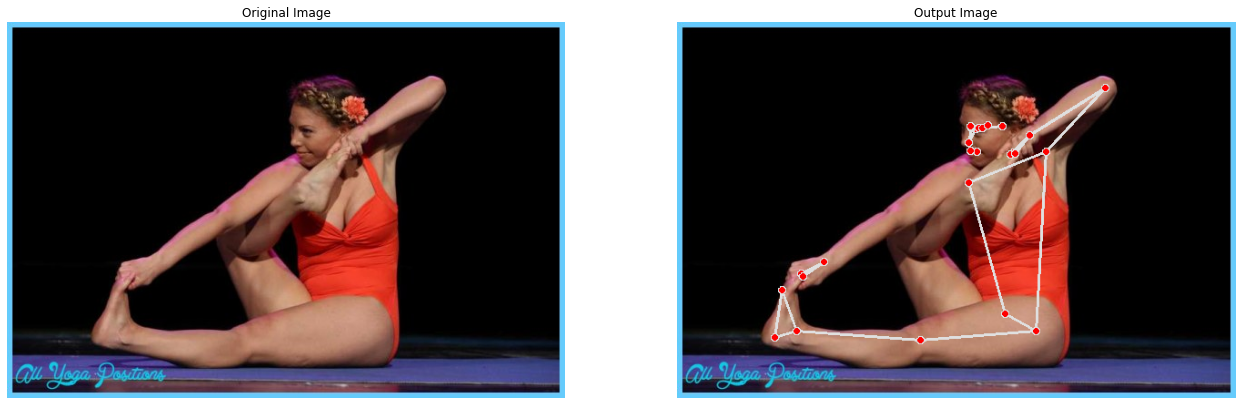

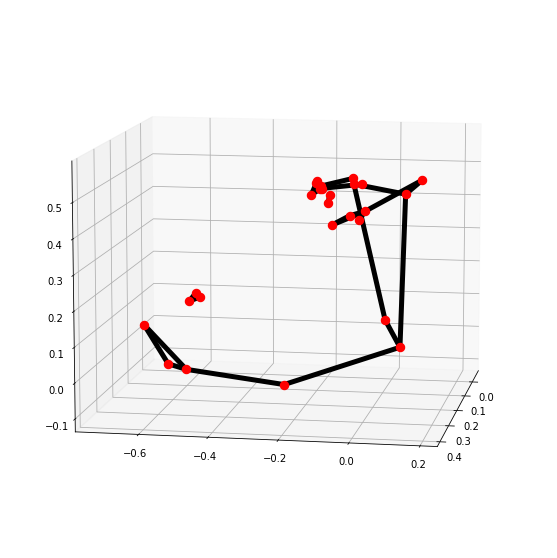

In [13]:
# This is a quick tool I made to filter out images that the pose estimator does poorly on.
# See good and bad json. 
# To use, press play, then you'll see an image with the pose estimation on top.
# If the pose estimation is good, simply press enter in the command prompt and it will be added to good.
# If the estimation is bad, enter 'k', and if you'd like to skip to the next pose category, enter 's'.
# Finally enter 's' again if you'd like to exit the tool.
# Do not just pause the notebook because your progress will not be stored in the json files.

# This is just one possible (partial) solution, by no means do I think we NEED to do this right away.

goods, bads = load_chechpoint(myPath)

for folder in myYogaFolders:

    posePath = os.path.join(myYogaPath, folder)
    myYogaImages = os.listdir(posePath)

    for imageName in myYogaImages:

        if imageName in goods[folder] or imageName in bads[folder]:
            continue

        imagePath = os.path.join(posePath, imageName)
        image = cv2.imread(imagePath)
        detectPose(image, pose, display=True)

        x = input()
        if x == 's':
            clear_output(wait=True)
            break
        elif x == 'k':
            bads[folder].append(image)
        else:
            goods[folder].append(image)
        
        clear_output(wait=True)

    x = input()
    if x == 's':
        break

save_chechpoint(goods, bads)